# Covid CNN

Disciplina: COC891 

Autores: Eric, Paula 

Data: 03/12/2020 - Load dataset, CNN "basico"

In [2]:
# Import
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, argparse, pathlib
from eval import eval
import itertools
from data import process_image_file
from data import apply_augmentation

In [3]:
# Definicao de Parametros
trainFile = 'train_split.txt'
valFile = 'val_split.txt'
testFile = 'test_split.txt'
datadir = '..\\data\\'
trainDir = 'train'
valDir = 'train'
testDir = 'test'
covid_percent= 0.3
input_size = 480
top_percent = 0.08
batch_size = 10

In [4]:
def getItem(n,
            batch_size,
            input_shape,
            num_channels,
            datasets,
            covid_percent,
            data_dir,
            tipo_dir,
            top_percent,
            augmentation,
            mapping):
    
    batch_x, batch_y = np.zeros((batch_size, *input_shape, num_channels)), np.zeros(batch_size)

    batch_files = datasets[0][n * batch_size:(n + 1) * batch_size]
    
    # upsample covid cases
    covid_size = max(int(len(batch_files) * covid_percent), 1)
    covid_inds = np.random.choice(np.arange(len(batch_files)), size=covid_size, replace=False)
    covid_files = np.random.choice(datasets[1], size=covid_size, replace=False)
    for i in range(covid_size):
        batch_files[covid_inds[i]] = covid_files[i]

    for i in range(len(batch_files)):
        sample = batch_files[i].split()

        folder = tipo_dir

        x = process_image_file(os.path.join(data_dir, folder, sample[1]),
                               top_percent,
                               input_shape[0])

        if augmentation:
            x = apply_augmentation(x)

        x = x.astype('float32') / 255.0
        y = mapping[sample[2]]

        batch_x[i] = x
        batch_y[i] = y
        
    return batch_x, batch_y

In [5]:
def gen_batch(data_dir,
              tipo_dir,
              csv_file,
              batch_size,
              input_shape,
              num_channels,
              covid_percent,
              top_percent):
    
    with open(csv_file, 'r') as fr:
        dataset = fr.readlines()
        
    mapping={
                'normal': 0,
                'pneumonia': 1,
                'COVID-19': 2
            }
    n = 0
    
    datasets = {'normal': [], 'pneumonia': [], 'COVID-19': []}
    for l in dataset:
        datasets[l.split()[2]].append(l)
        
    datasets = [
        datasets['normal'] + datasets['pneumonia'],
        datasets['COVID-19'],
    ]
    
    N = int(np.floor(len(datasets[0]) / float(batch_size)))
    print(N)
    
    if tipo_dir != testDir:
        augmentation = True
    else:
        augmentation = False
            
    while True:
        batch_x, batch_y = getItem(n,
            batch_size,
            input_shape,
            num_channels,
            datasets,
            covid_percent,
            data_dir,
            tipo_dir,
            top_percent,
            augmentation,
            mapping)
    
        n = n + 1
        if n >= N:
            n = 0
            for v in datasets:
                np.random.shuffle(v)
                
        yield(batch_x, batch_y)

In [6]:
generator_train = gen_batch(data_dir = datadir,
              tipo_dir = trainDir,
              csv_file = trainFile,
              batch_size = batch_size,
              input_shape = (input_size, input_size),
              num_channels = 3,
              covid_percent = covid_percent,
              top_percent = top_percent)

In [7]:
generator_val = gen_batch(data_dir = datadir,
              tipo_dir = valDir,
              csv_file = valFile,
              batch_size = batch_size,
              input_shape = (input_size, input_size),
              num_channels = 3,
              covid_percent = covid_percent,
              top_percent = top_percent)

In [8]:
testeX, testeY = next(generator_train)

1045


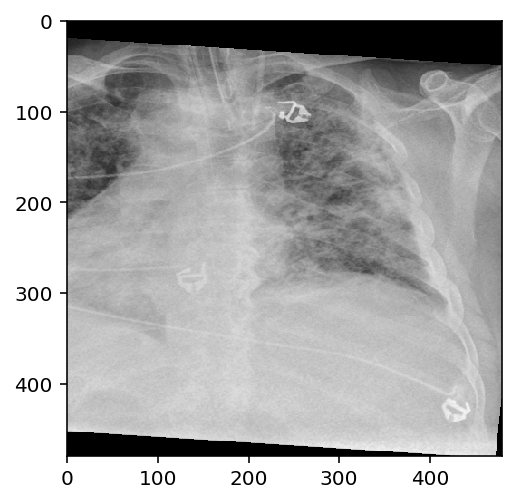

In [9]:
plt.imshow(testeX[1,:,:,:], cmap=plt.cm.binary)
plt.show()

In [10]:
valX, valY = next(generator_val)

298


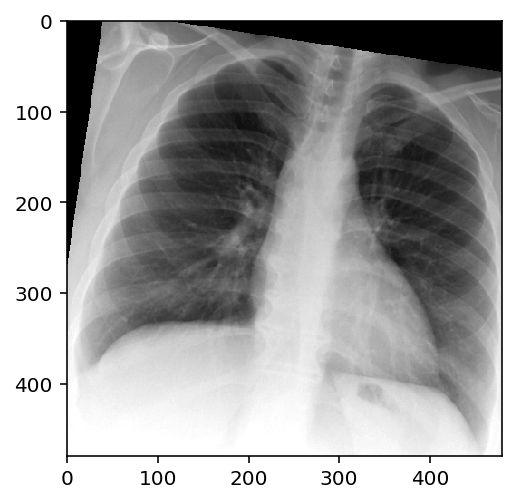

In [11]:
plt.imshow(valX[1,:,:,:], cmap=plt.cm.binary)
plt.show()

In [12]:
# CNN Architecture
model = keras.Sequential([
    keras.layers.Conv2D(20, kernel_size=3, activation='relu', input_shape=(480,480,3), padding='valid'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=None),
    keras.layers.Conv2D(10, kernel_size=3, activation='relu', input_shape=(480,480,3), padding='valid'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=None),
    keras.layers.Flatten(),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [13]:
# Model Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Callbacks Definition
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('covid_cnn_model.h5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [15]:
# fit
model.fit(generator_train, epochs=30, steps_per_epoch=1045, class_weight = {0 : 1,1 : 1, 2: 4},
         validation_data=generator_val, validation_steps=298, verbose=True, callbacks=[earlyStopping, mcp_save])
#history = model.fit(X_train, label_train, batch_size=10, validation_data=(X_val,label_val), epochs=1,
#                    verbose=True, callbacks=[earlyStopping, mcp_save])

Epoch 1/30
1045/1045 [==============================] - 1239s 1s/step - loss: 1.1130 - accuracy: 0.6330 - val_loss: 3.8988 - val_accuracy: 0.3953
Epoch 2/30
1045/1045 [==============================] - 1207s 1s/step - loss: 1.5252 - accuracy: 0.4000 - val_loss: 1.2228 - val_accuracy: 0.4272
Epoch 3/30
1045/1045 [==============================] - 1157s 1s/step - loss: 1.4516 - accuracy: 0.4528 - val_loss: 1.0813 - val_accuracy: 0.4772
Epoch 4/30
1045/1045 [==============================] - 1147s 1s/step - loss: 1.4147 - accuracy: 0.4912 - val_loss: 1.0487 - val_accuracy: 0.5023
Epoch 5/30
1045/1045 [==============================] - 1130s 1s/step - loss: 1.3229 - accuracy: 0.5431 - val_loss: 0.9495 - val_accuracy: 0.5597
Epoch 6/30
1045/1045 [==============================] - 1061s 1s/step - loss: 1.2129 - accuracy: 0.5893 - val_loss: 0.8910 - val_accuracy: 0.6161
Epoch 7/30
1045/1045 [==============================] - 1046s 1s/step - loss: 1.1348 - accuracy: 0.6332 - val_loss: 0.8489 -

In [16]:
generator_test = gen_batch(data_dir = datadir,
              tipo_dir = testDir,
              csv_file = testFile,
              batch_size = batch_size,
              input_shape = (input_size, input_size),
              num_channels = 3,
              covid_percent = covid_percent,
              top_percent = top_percent)

In [17]:
testX, testY = next(generator_test)

147


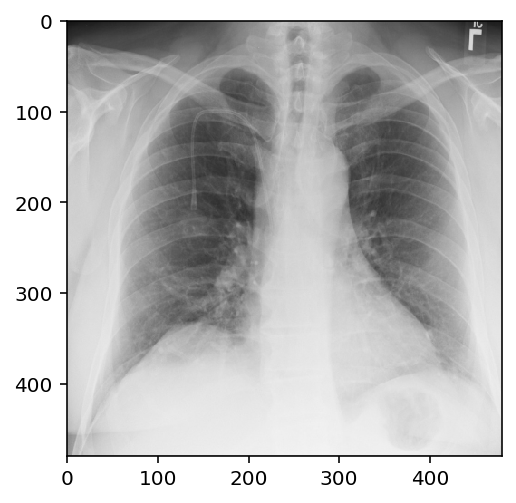

In [18]:
plt.imshow(testX[1,:,:,:], cmap=plt.cm.binary)
plt.show()

In [19]:
# Accuracy Evaluation

test_loss, test_acc = model.evaluate(generator_test, steps = 147)

147/147 [==============================] - 80s 543ms/step - loss: 0.7839 - accuracy: 0.7320


In [21]:
testY

array([0., 0., 0., 2., 2., 2., 0., 0., 0., 0.])

In [25]:
pred = model.predict(testX)
np.argmax(pred, axis=1)

array([0, 0, 0, 2, 1, 2, 0, 0, 0, 0], dtype=int64)

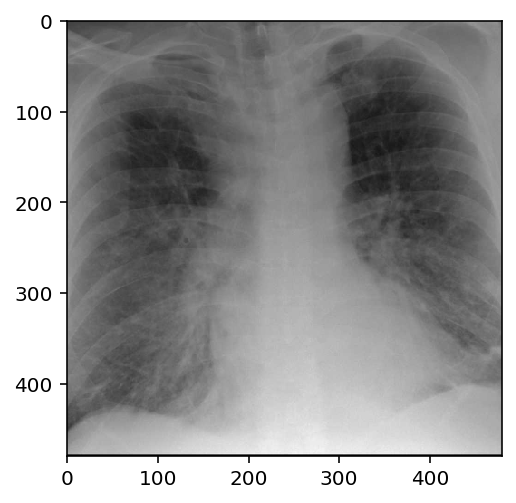

In [26]:
plt.imshow(testX[3,:,:,:], cmap=plt.cm.binary)
plt.show()